# Shampoo dataset time series forecasting

In [262]:
%ls

basic_plot.png       shampoo.md
boxplot_shampoo.png  shampoo-saled-dataset.zip
img/                 shampoo_sales.csv
month_plot.png       shampoo_sales_time_series_forecasting.ipynb
output.txt           year_plot.png


In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [264]:
# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


In [265]:
df = pd.read_csv('shampoo_sales.csv',
                index_col='Month')

df.head(12)


,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3
1-06,168.5
1-07,231.8
1-08,224.5
1-09,192.8


In [266]:
df.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [267]:
def custom_date_parser(date):
    year = 1981 + int(date.split('-')[0]) - 1
    month = int(date.split('-')[1])
    return pd.to_datetime(f'{year}-{month:02}')

In [268]:
df.index = df.index.to_series().apply(custom_date_parser)
# df.index = df.index.strftime('%Y-%m')

In [269]:
print(df.index.dtype)

datetime64[ns]


In [270]:
df = df.to_period()

df.head()

,Sales
Month,
1981-01,266.0
1981-02,145.9
1981-03,183.1
1981-04,119.3
1981-05,180.3


In [271]:
df.index.dtype

period[M]

In [272]:
df.isnull().sum()

Sales    0
dtype: int64

In [273]:
# Nastavení stylu grafu
sns.set(style="whitegrid")

In [274]:
df['Month'] = np.arange(len(df.index))

df.head()

,Sales,Month
Month,,
1981-01,266.0,0
1981-02,145.9,1
1981-03,183.1,2
1981-04,119.3,3
1981-05,180.3,4


In [275]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 3.0601420836411806
p-value: 1.0


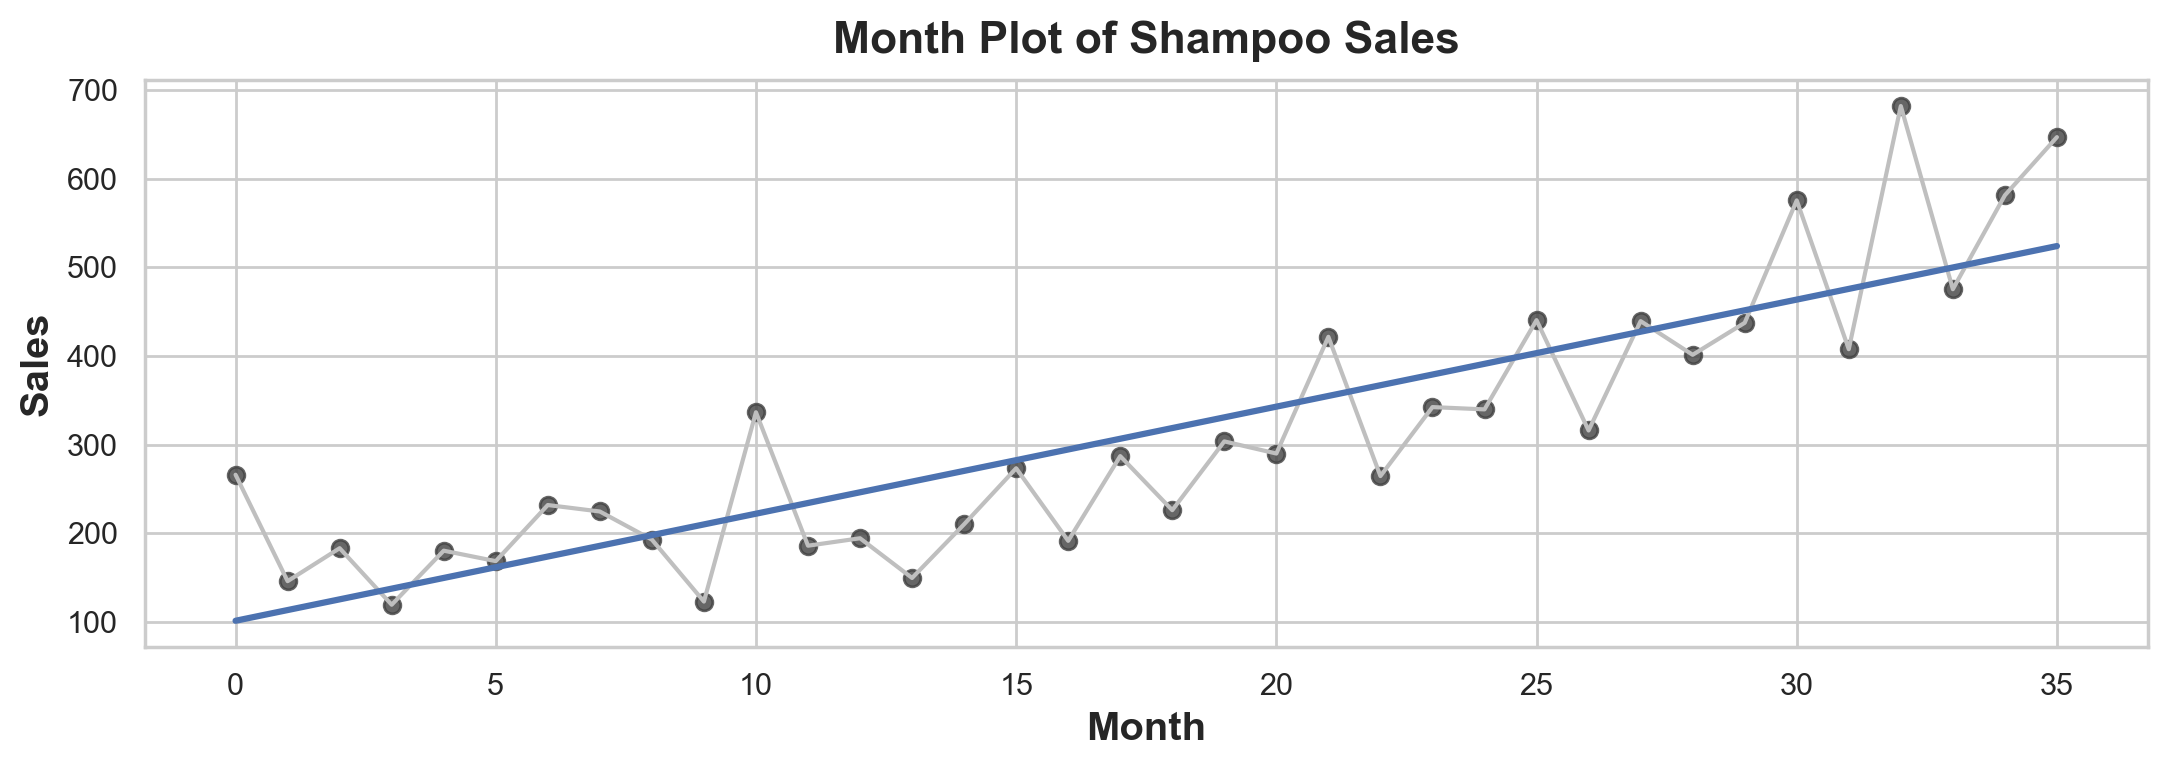

In [276]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Month', 'Sales', data=df, color='0.75')
ax = sns.regplot(x='Month', y='Sales', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Month Plot of Shampoo Sales')
fig.savefig('basic_plot.png')

/home/proky/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


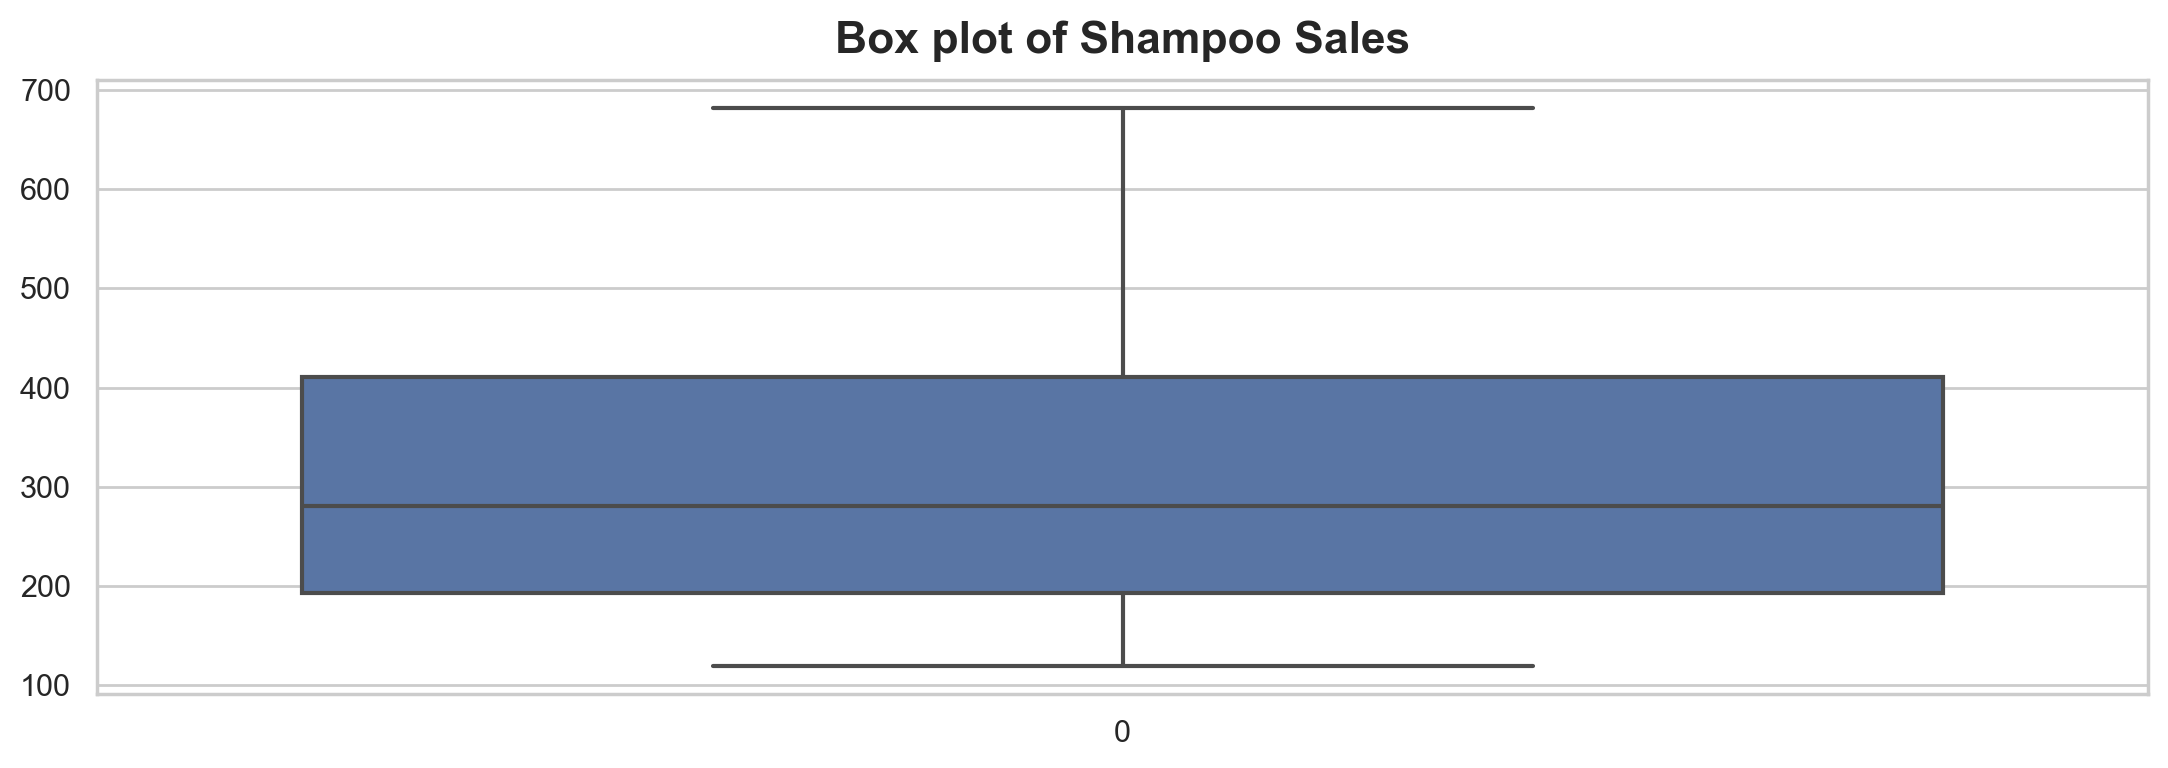

In [277]:
sns.boxplot(df['Sales'])
plt.title('Box plot of Shampoo Sales')
plt.savefig('boxplot_shampoo.png')
plt.show()

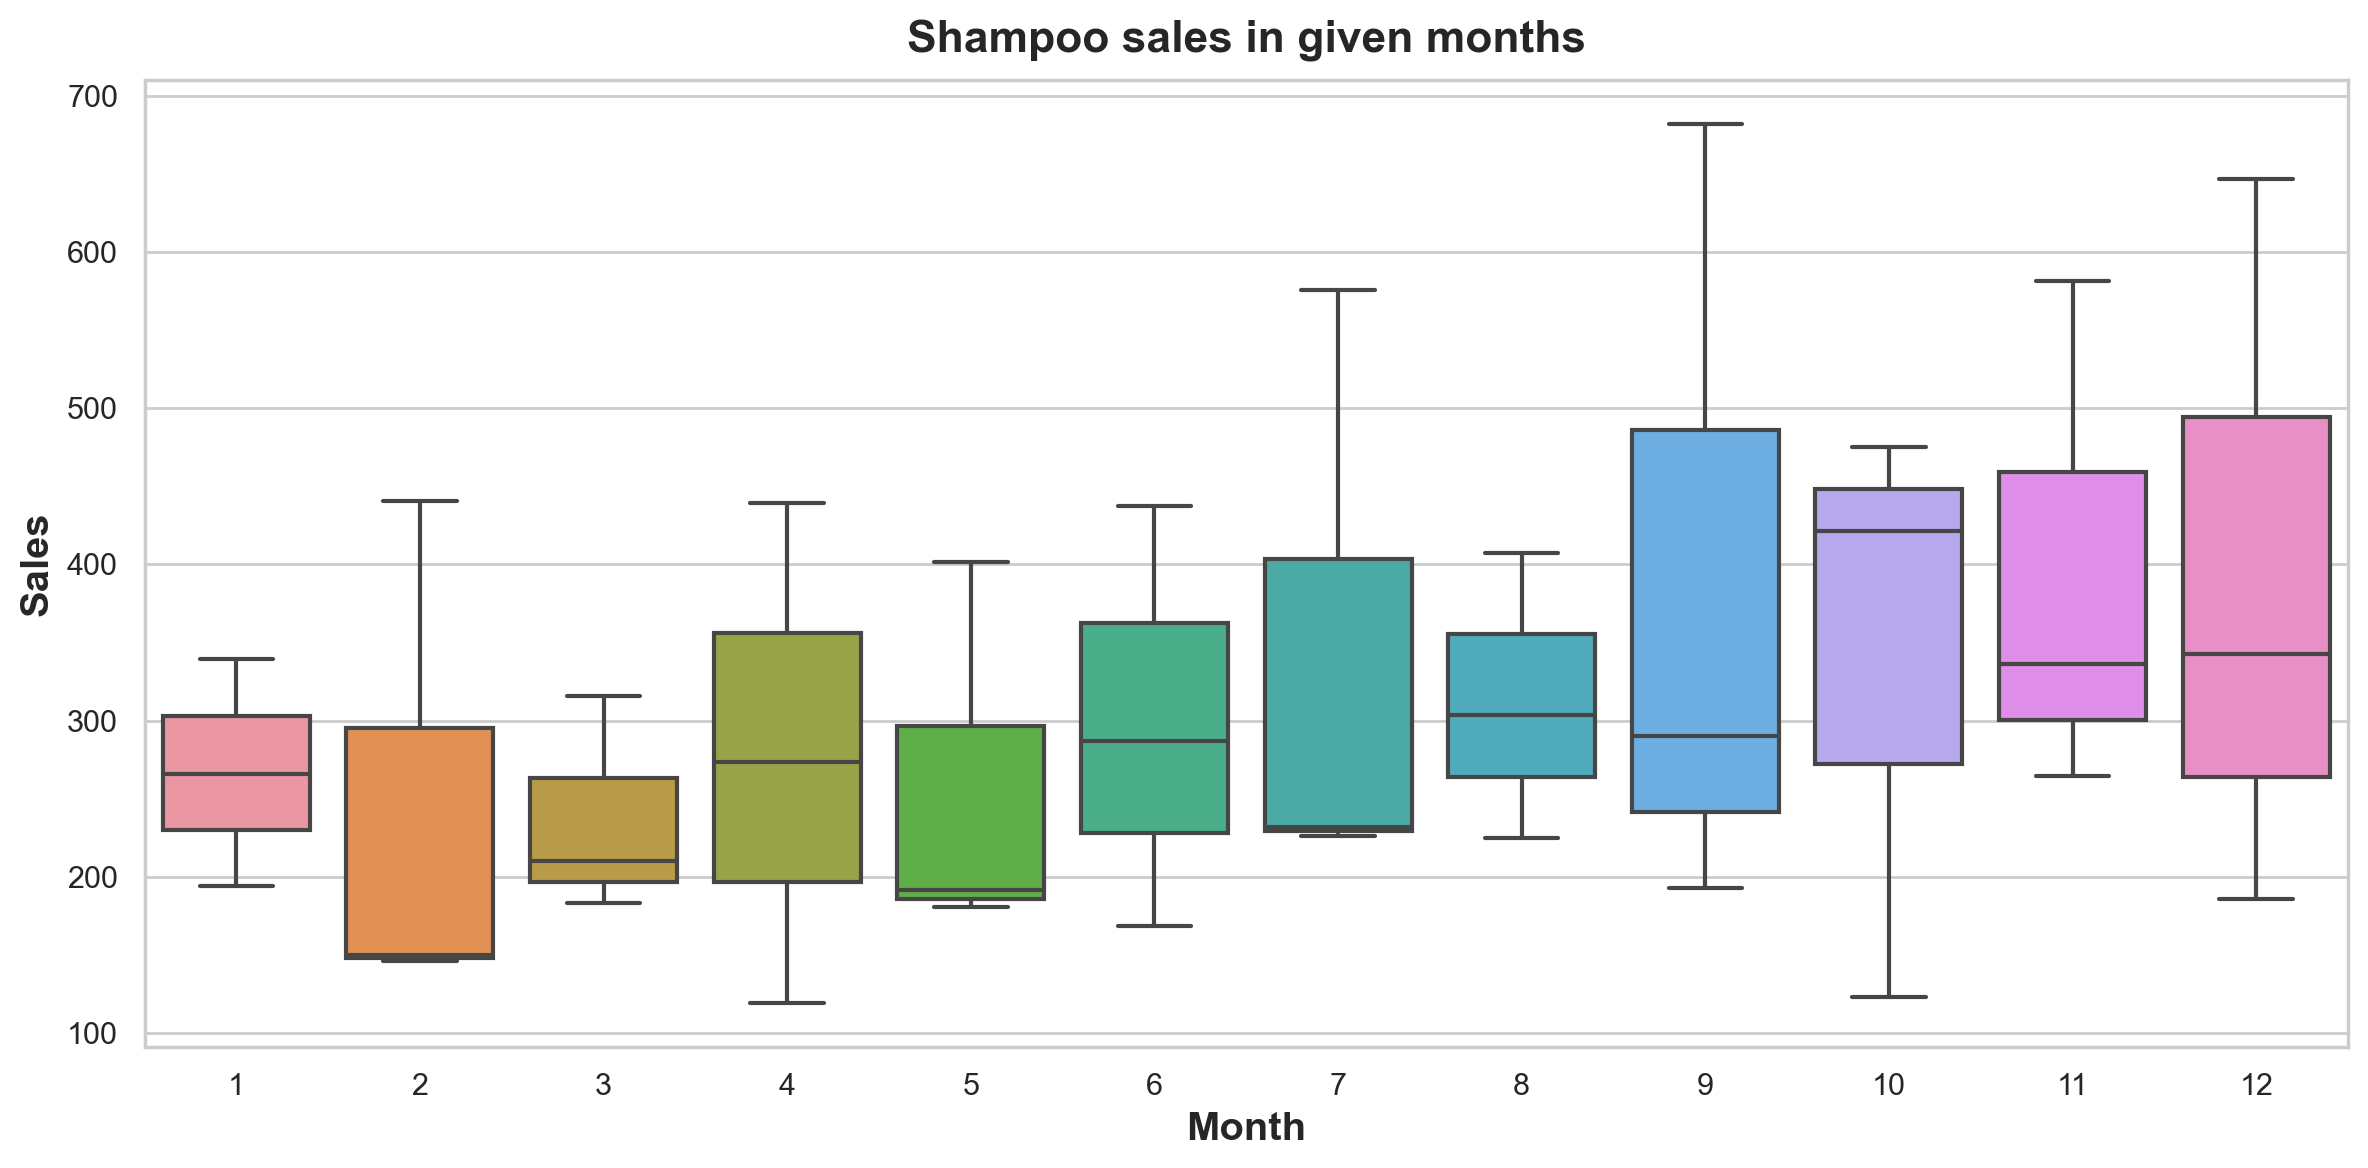

In [278]:
df['Month'] = df.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Sales', data=df)
plt.title('Shampoo sales in given months')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.savefig('month_plot.png')
plt.show()

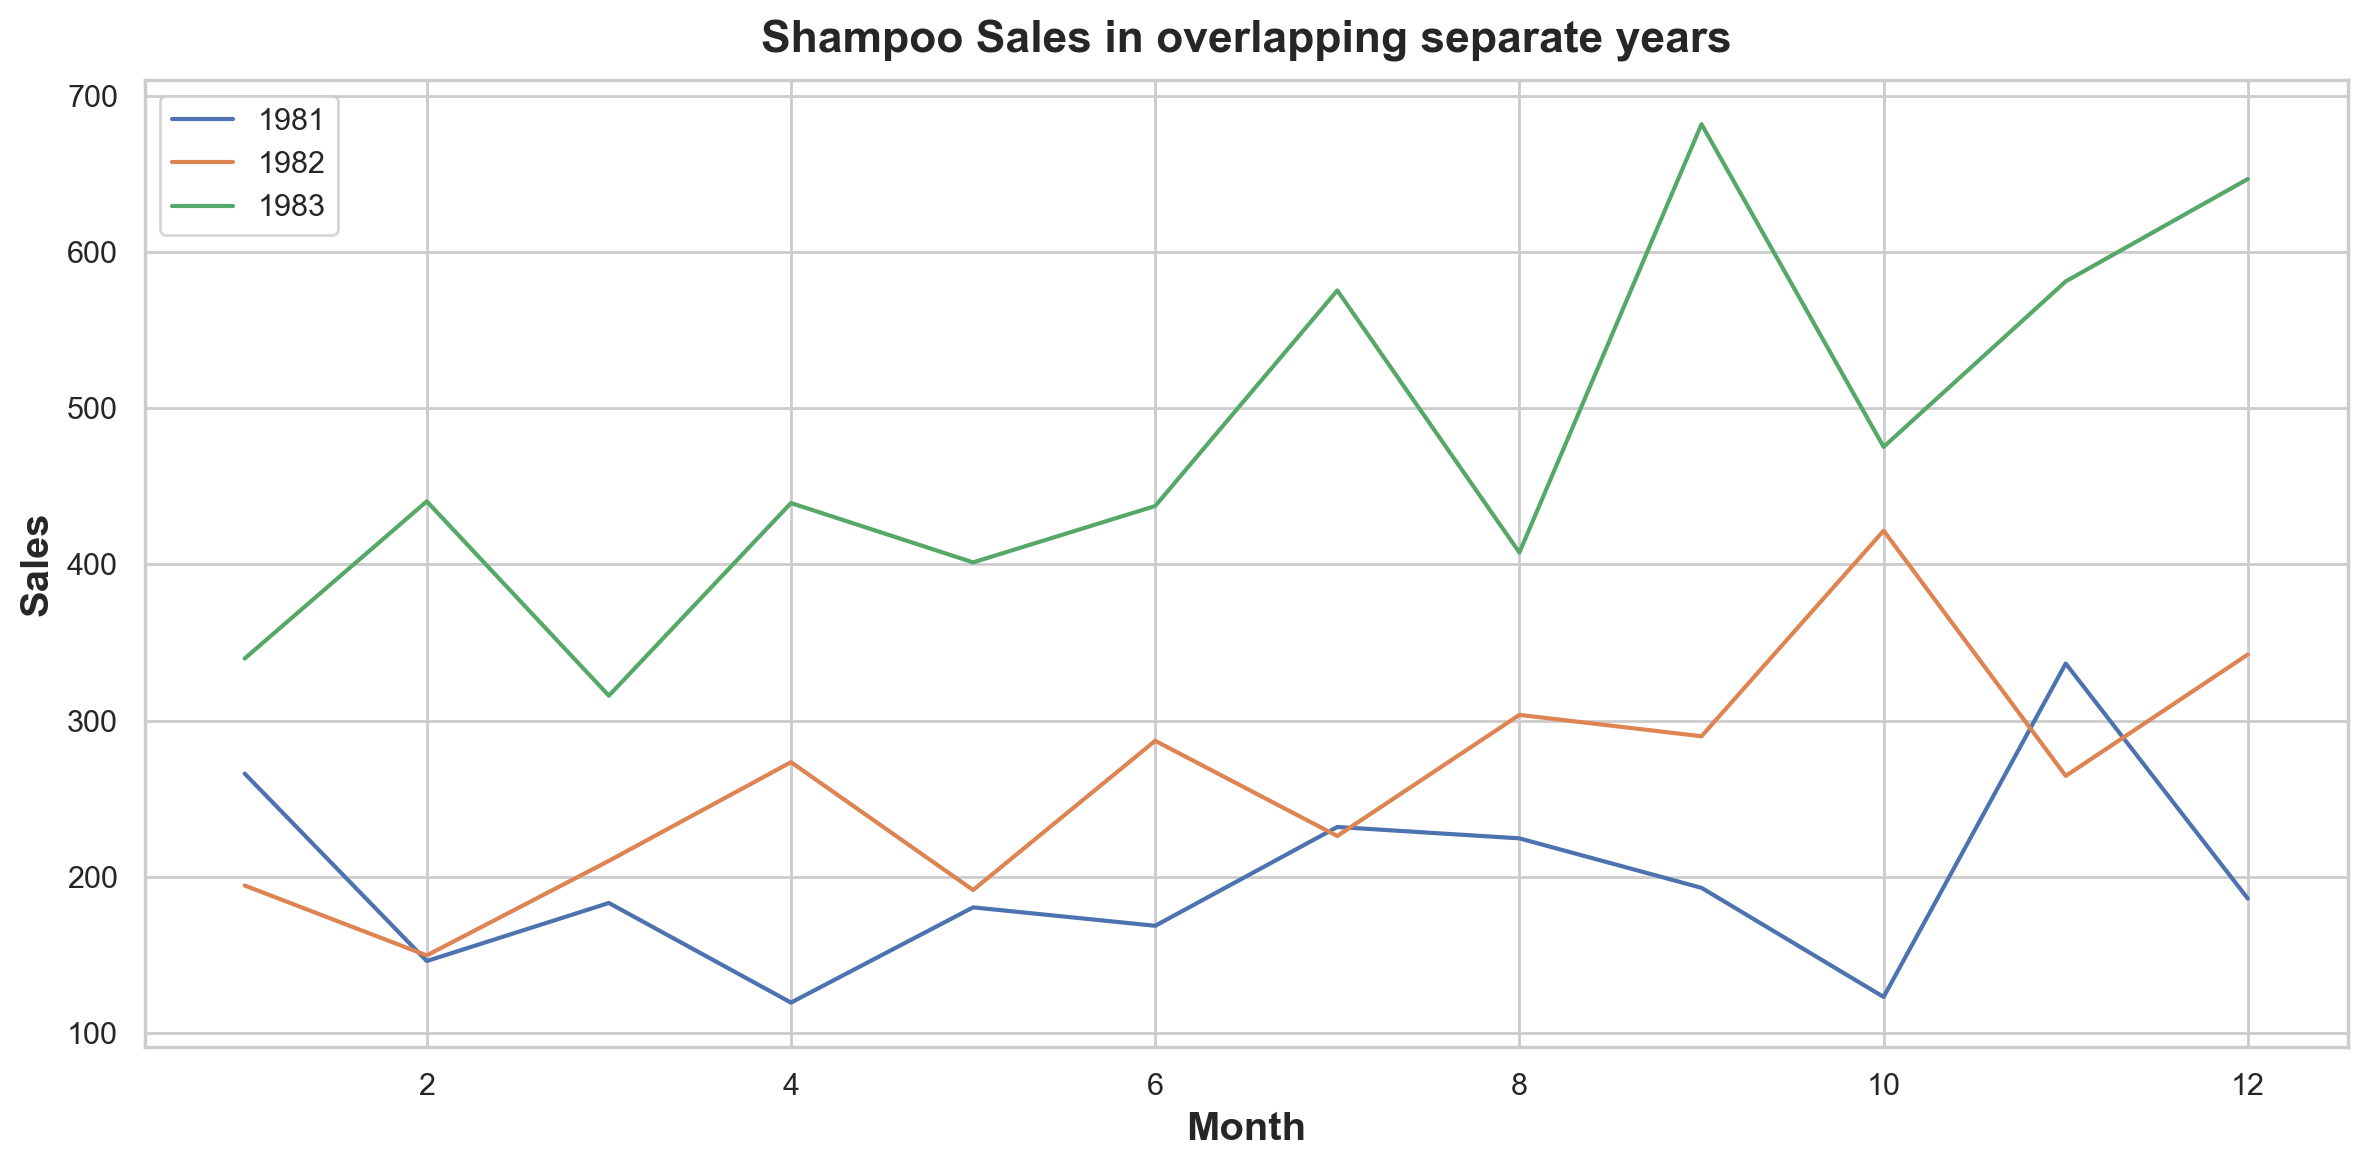

In [279]:
df['year'] = df.index.year
plt.figure(figsize=(12, 6))
for year in df['year'].unique():
    plt.plot(df[df['year'] == year].index.month, df[df['year'] == year]['Sales'], label=str(year))

plt.title('Shampoo Sales in overlapping separate years')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.savefig('year_plot.png')
plt.show()


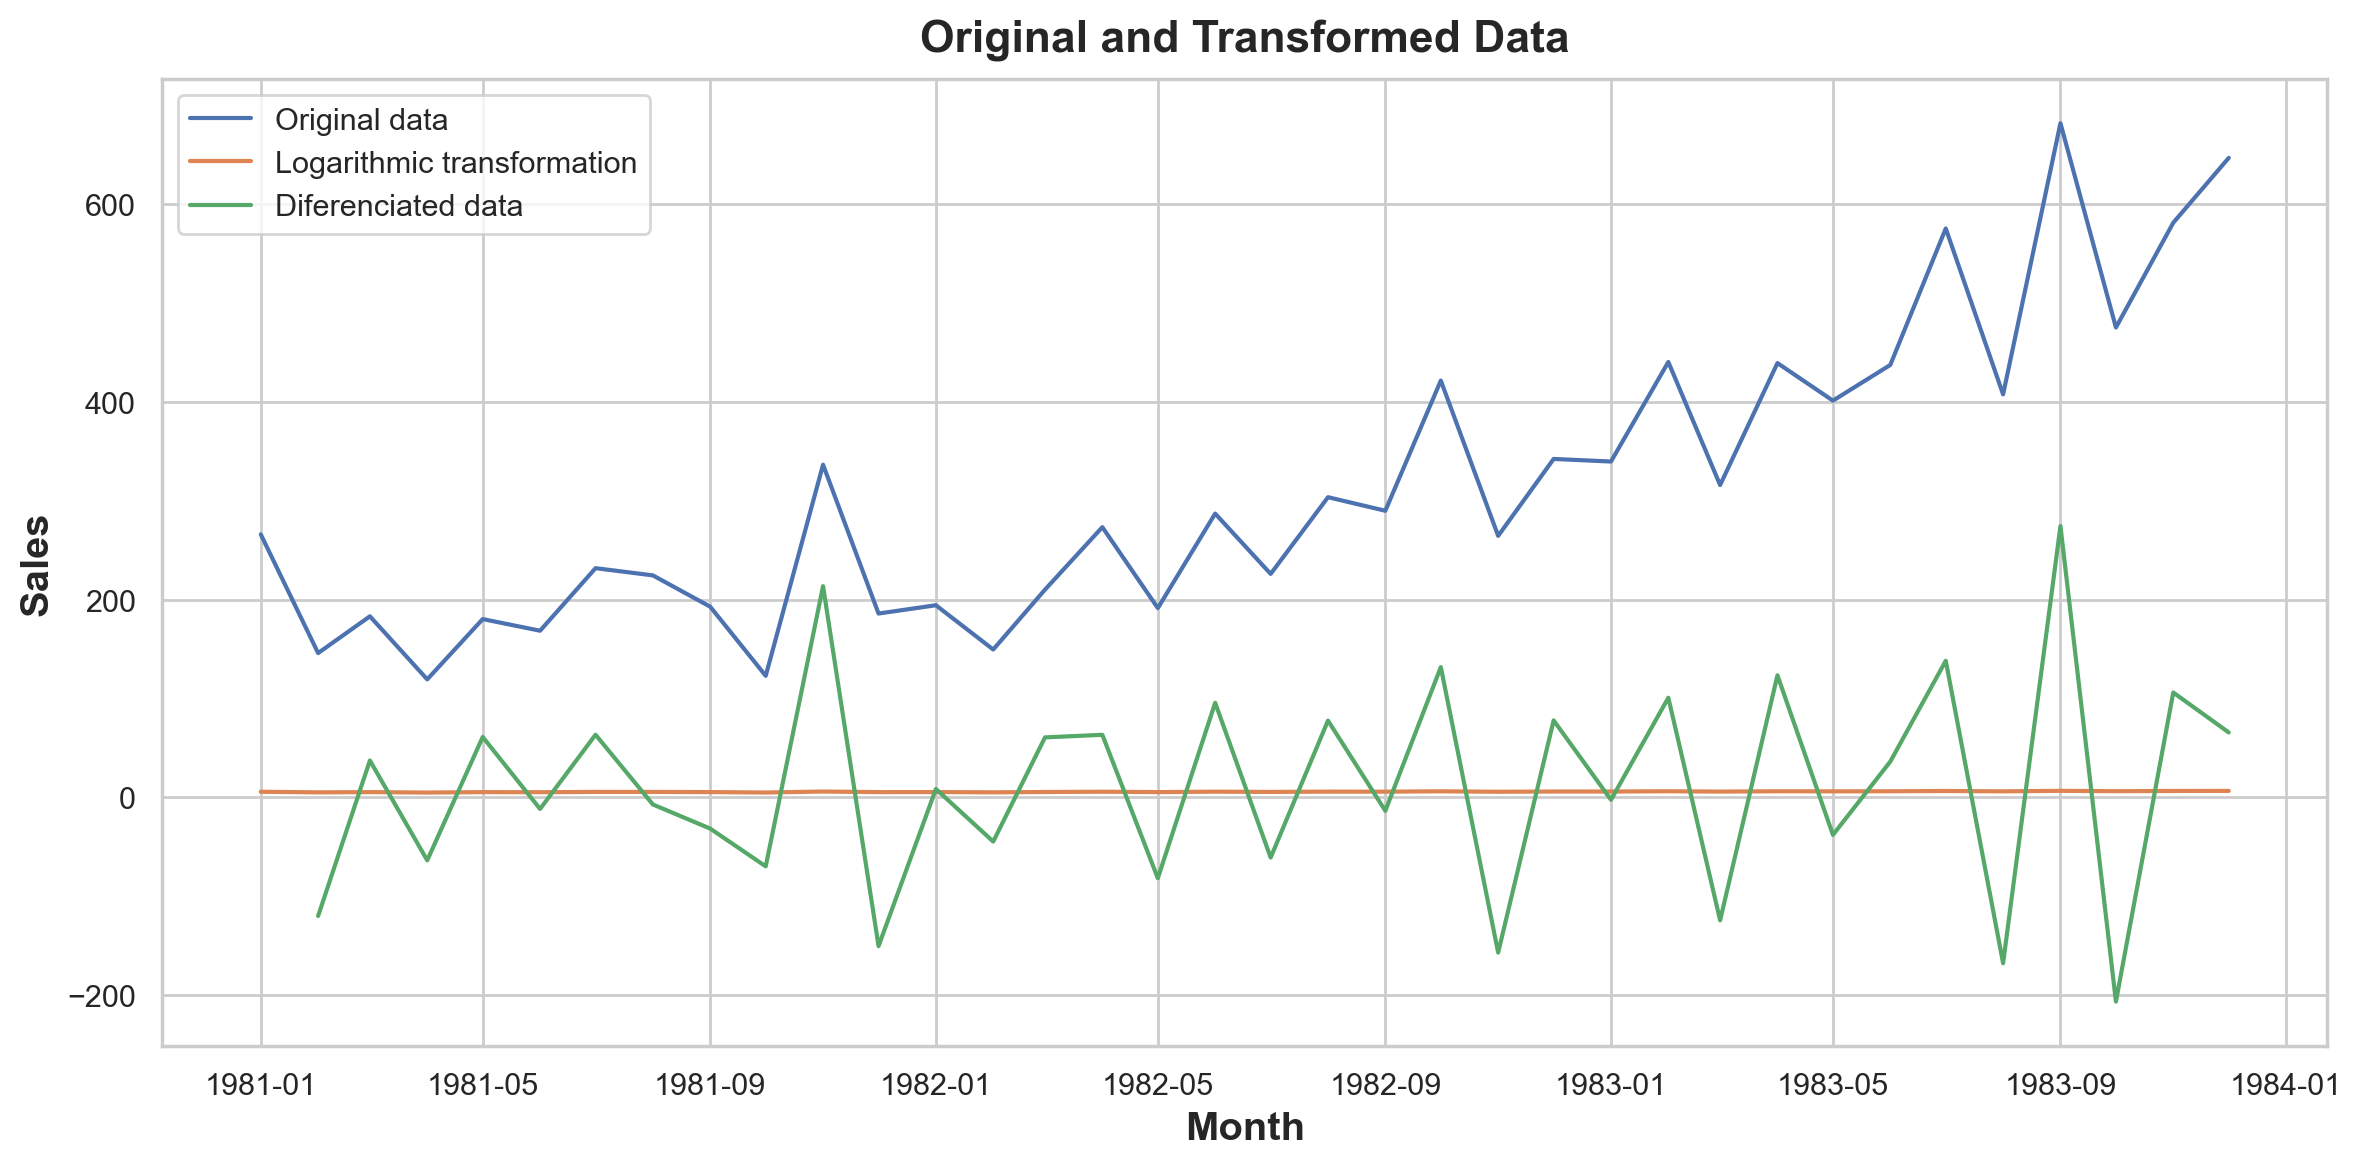

In [280]:
df['sales_log'] = np.log(df['Sales'])
df['sales_diff'] = df['Sales'].diff().dropna()

df.index = df.index.to_timestamp()

# Vykreslení původních a upravených dat
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Original data')
plt.plot(df.index, df['sales_log'], label='Logarithmic transformation')
plt.plot(df.index, df['sales_diff'], label='Diferenciated data')
plt.legend()
plt.title('Original and Transformed Data')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

## Fitting a linear regression model for Month feature

In [281]:
df.head()

,Sales,Month,year,sales_log,sales_diff
Month,,,,,
1981-01-01,266.0,1,1981,5.583496,NaN
1981-02-01,145.9,2,1981,4.982921,-120.1
1981-03-01,183.1,3,1981,5.210032,37.2
1981-04-01,119.3,4,1981,4.781641,-63.8
1981-05-01,180.3,5,1981,5.194622,61.0


In [282]:
# Training data
X = df.loc[:, ['Month']] # features
y = df.loc[:, 'Sales'] # target

# Train model
model = LinearRegression()
model.fit(X,y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

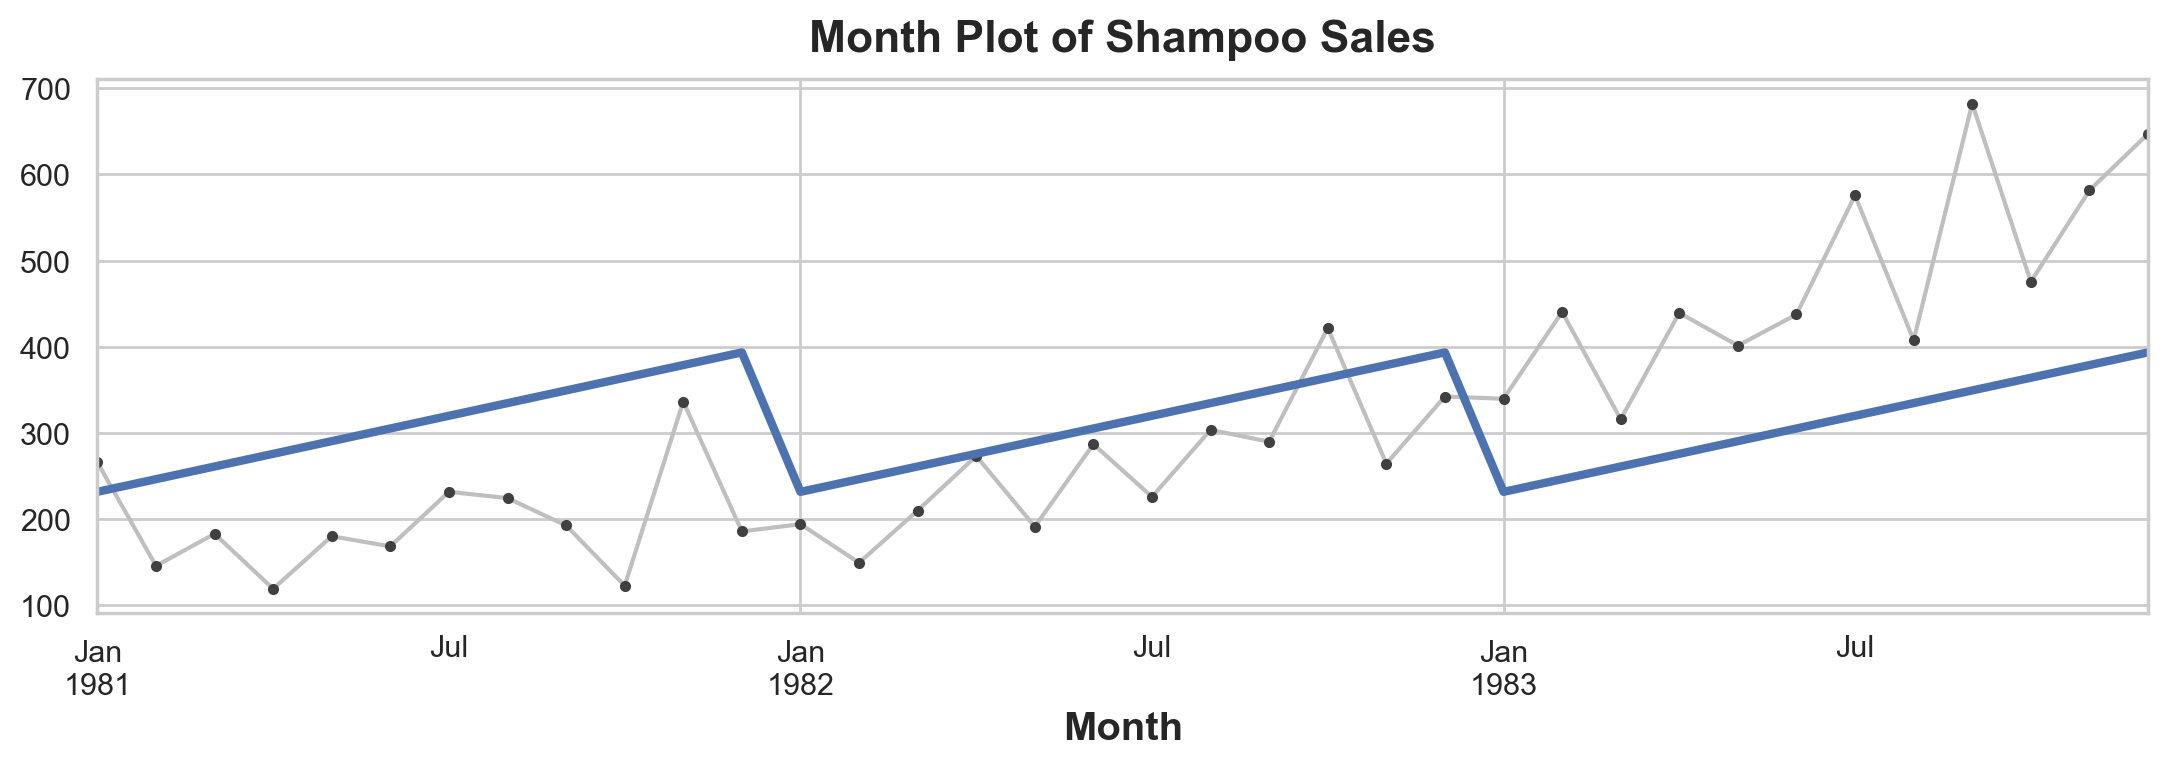

In [283]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Month Plot of Shampoo Sales');
plt.show()

## Adding Lag feature

In [284]:
df['Lag_1'] = df['Sales'].shift(1)
df = df.reindex(columns=['Sales', 'Lag_1'])

df.head()

,Sales,Lag_1
Month,,
1981-01-01,266.0,NaN
1981-02-01,145.9,266.0
1981-03-01,183.1,145.9
1981-04-01,119.3,183.1
1981-05-01,180.3,119.3


Text(0.5, 1.0, 'Lag Plot of Shampoo Sales')

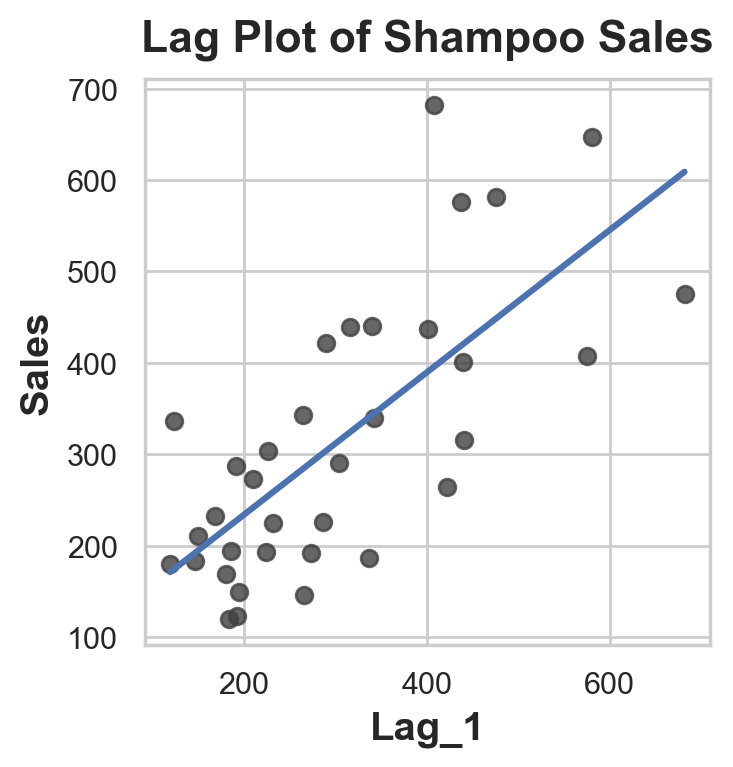

In [285]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Sales', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Shampoo Sales')

## Fitting a linear regression model for Lag feature

In [286]:
X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'Sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

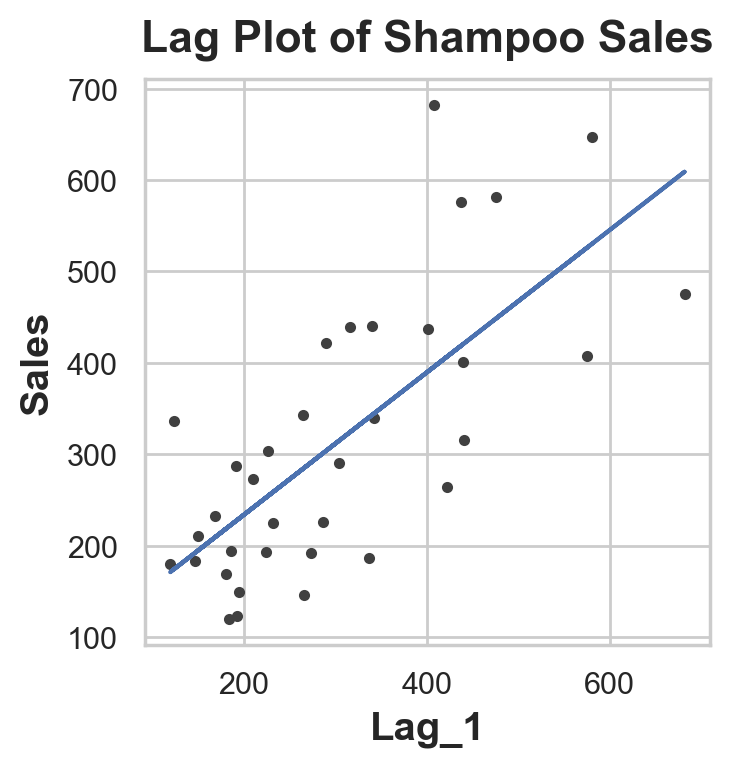

In [287]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Sales')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Shampoo Sales');

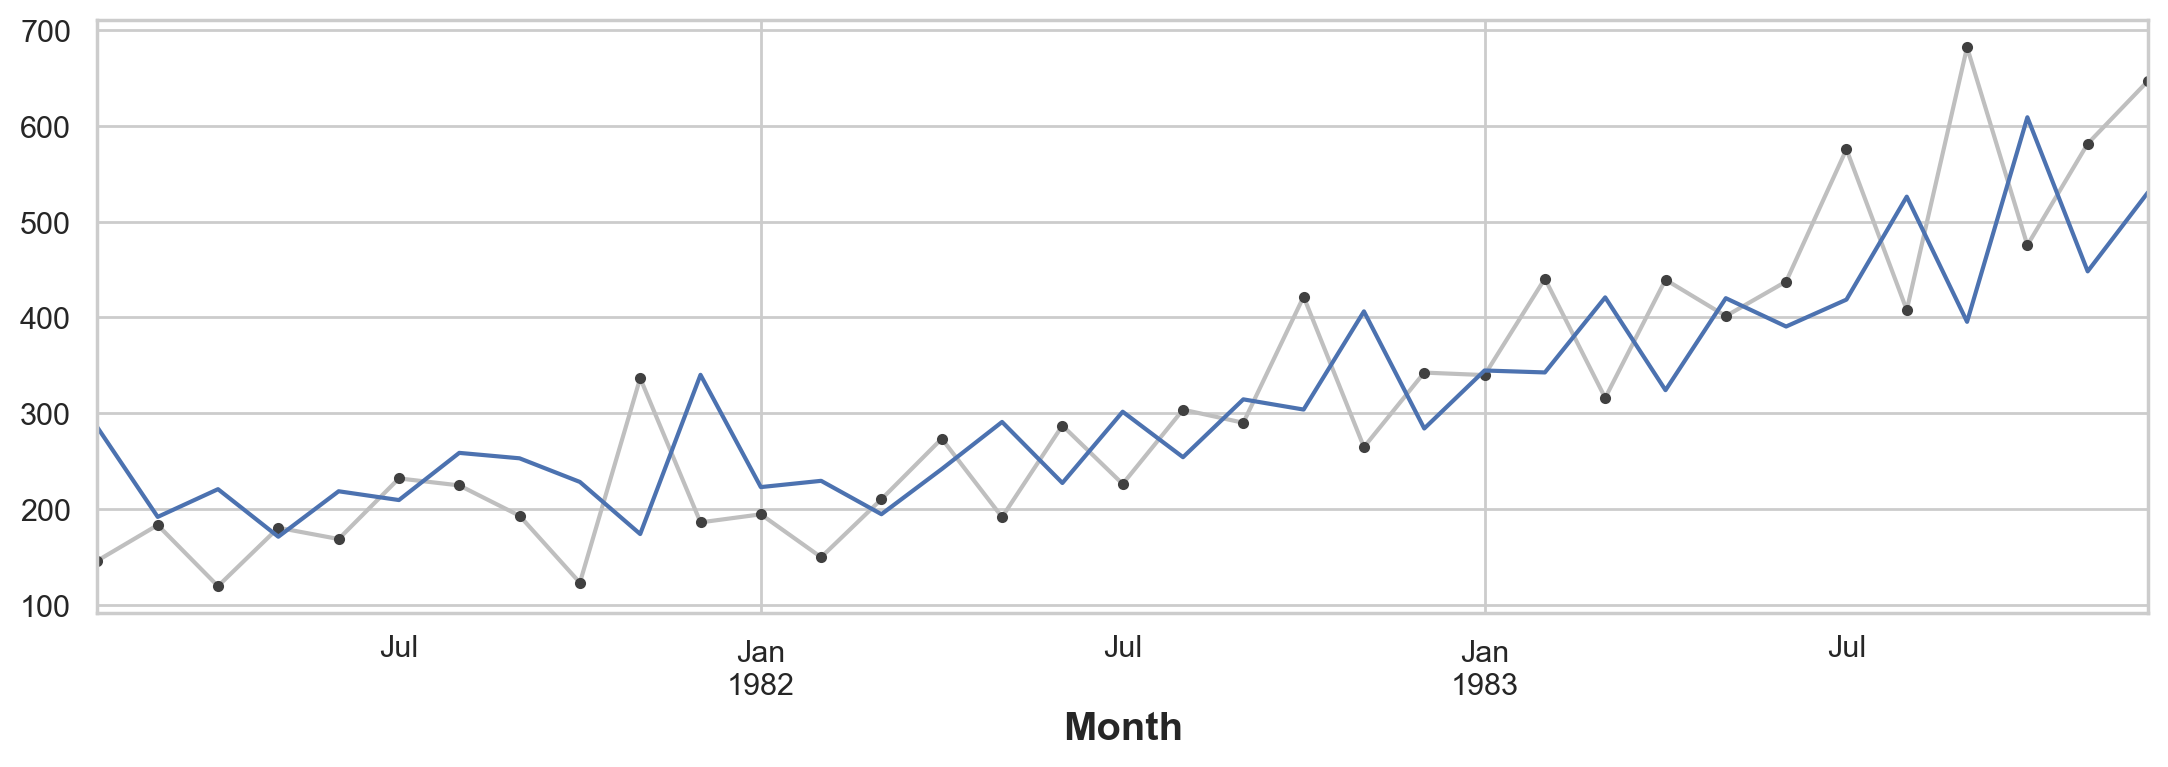

In [288]:
ax = y.plot(**plot_params)
ax = y_pred.plot()